In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fastai.vision.all import *
import random
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
train_df = pd.read_csv('Dataset/sign_mnist_train.csv')
test_df = pd.read_csv('Dataset/sign_mnist_test.csv')

In [3]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

def reconstruct_image(pixels):
    pixels = pixels.astype(np.uint8).reshape(28, 28)
    return Image.fromarray(pixels)

In [4]:
train_df['image'] = train_df.iloc[:, 1:].apply(lambda x: reconstruct_image(x.to_numpy()), axis=1)
valid_df['image'] = valid_df.iloc[:, 1:].apply(lambda x: reconstruct_image(x.to_numpy()), axis=1)
test_df['image'] = test_df.iloc[:, 1:].apply(lambda x: reconstruct_image(x.to_numpy()), axis=1)

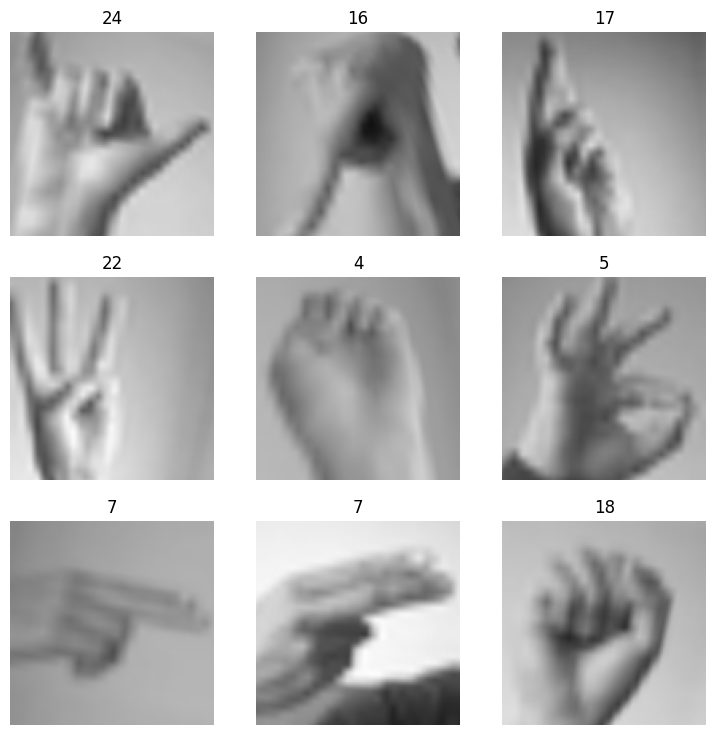

In [5]:
sign_language_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image'),
    get_y=ColReader('label'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(128),
    batch_tfms=[*aug_transforms(size=128, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]  
)

dls = sign_language_data.dataloaders(train_df, bs=32) 

dls.show_batch()

In [6]:
learn = vision_learner(dls, resnet50, metrics=accuracy)

learn.fine_tune(10, base_lr=1e-3, freeze_epochs=4, 
                cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=2)])

epoch,train_loss,valid_loss,accuracy,time
0,1.894613,1.142219,0.639344,00:59
1,1.077215,0.654620,0.786885,00:59
2,0.844050,0.509612,0.826730,00:59
3,0.637323,0.441641,0.858379,00:59


epoch,train_loss,valid_loss,accuracy,time
0,0.271585,0.160039,0.949681,01:18
1,0.109519,0.085014,0.982013,01:18
2,0.052476,0.063641,0.987933,01:18
3,0.030561,0.045619,0.992486,01:18
4,0.018591,0.027848,0.994308,01:19
5,0.016923,0.040043,0.996129,01:19
6,0.009807,0.039032,0.997268,01:19


No improvement since epoch 4: early stopping


Actual label: 6
Predicted label: 6


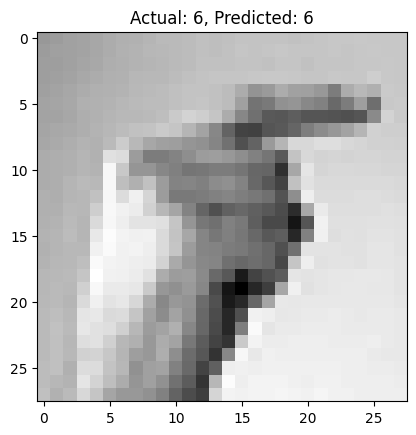

In [7]:
random_index = random.randint(0, len(test_df) - 1)

sample_image = test_df.iloc[random_index]['image']
actual_label = test_df.iloc[random_index]['label']

sample_image = PILImage.create(sample_image)

pred_class, pred_idx, outputs = learn.predict(sample_image)

print(f"Actual label: {actual_label}")
print(f"Predicted label: {pred_class}")

import matplotlib.pyplot as plt

plt.imshow(np.array(sample_image), cmap='gray')
plt.title(f"Actual: {actual_label}, Predicted: {pred_class}")
plt.show()

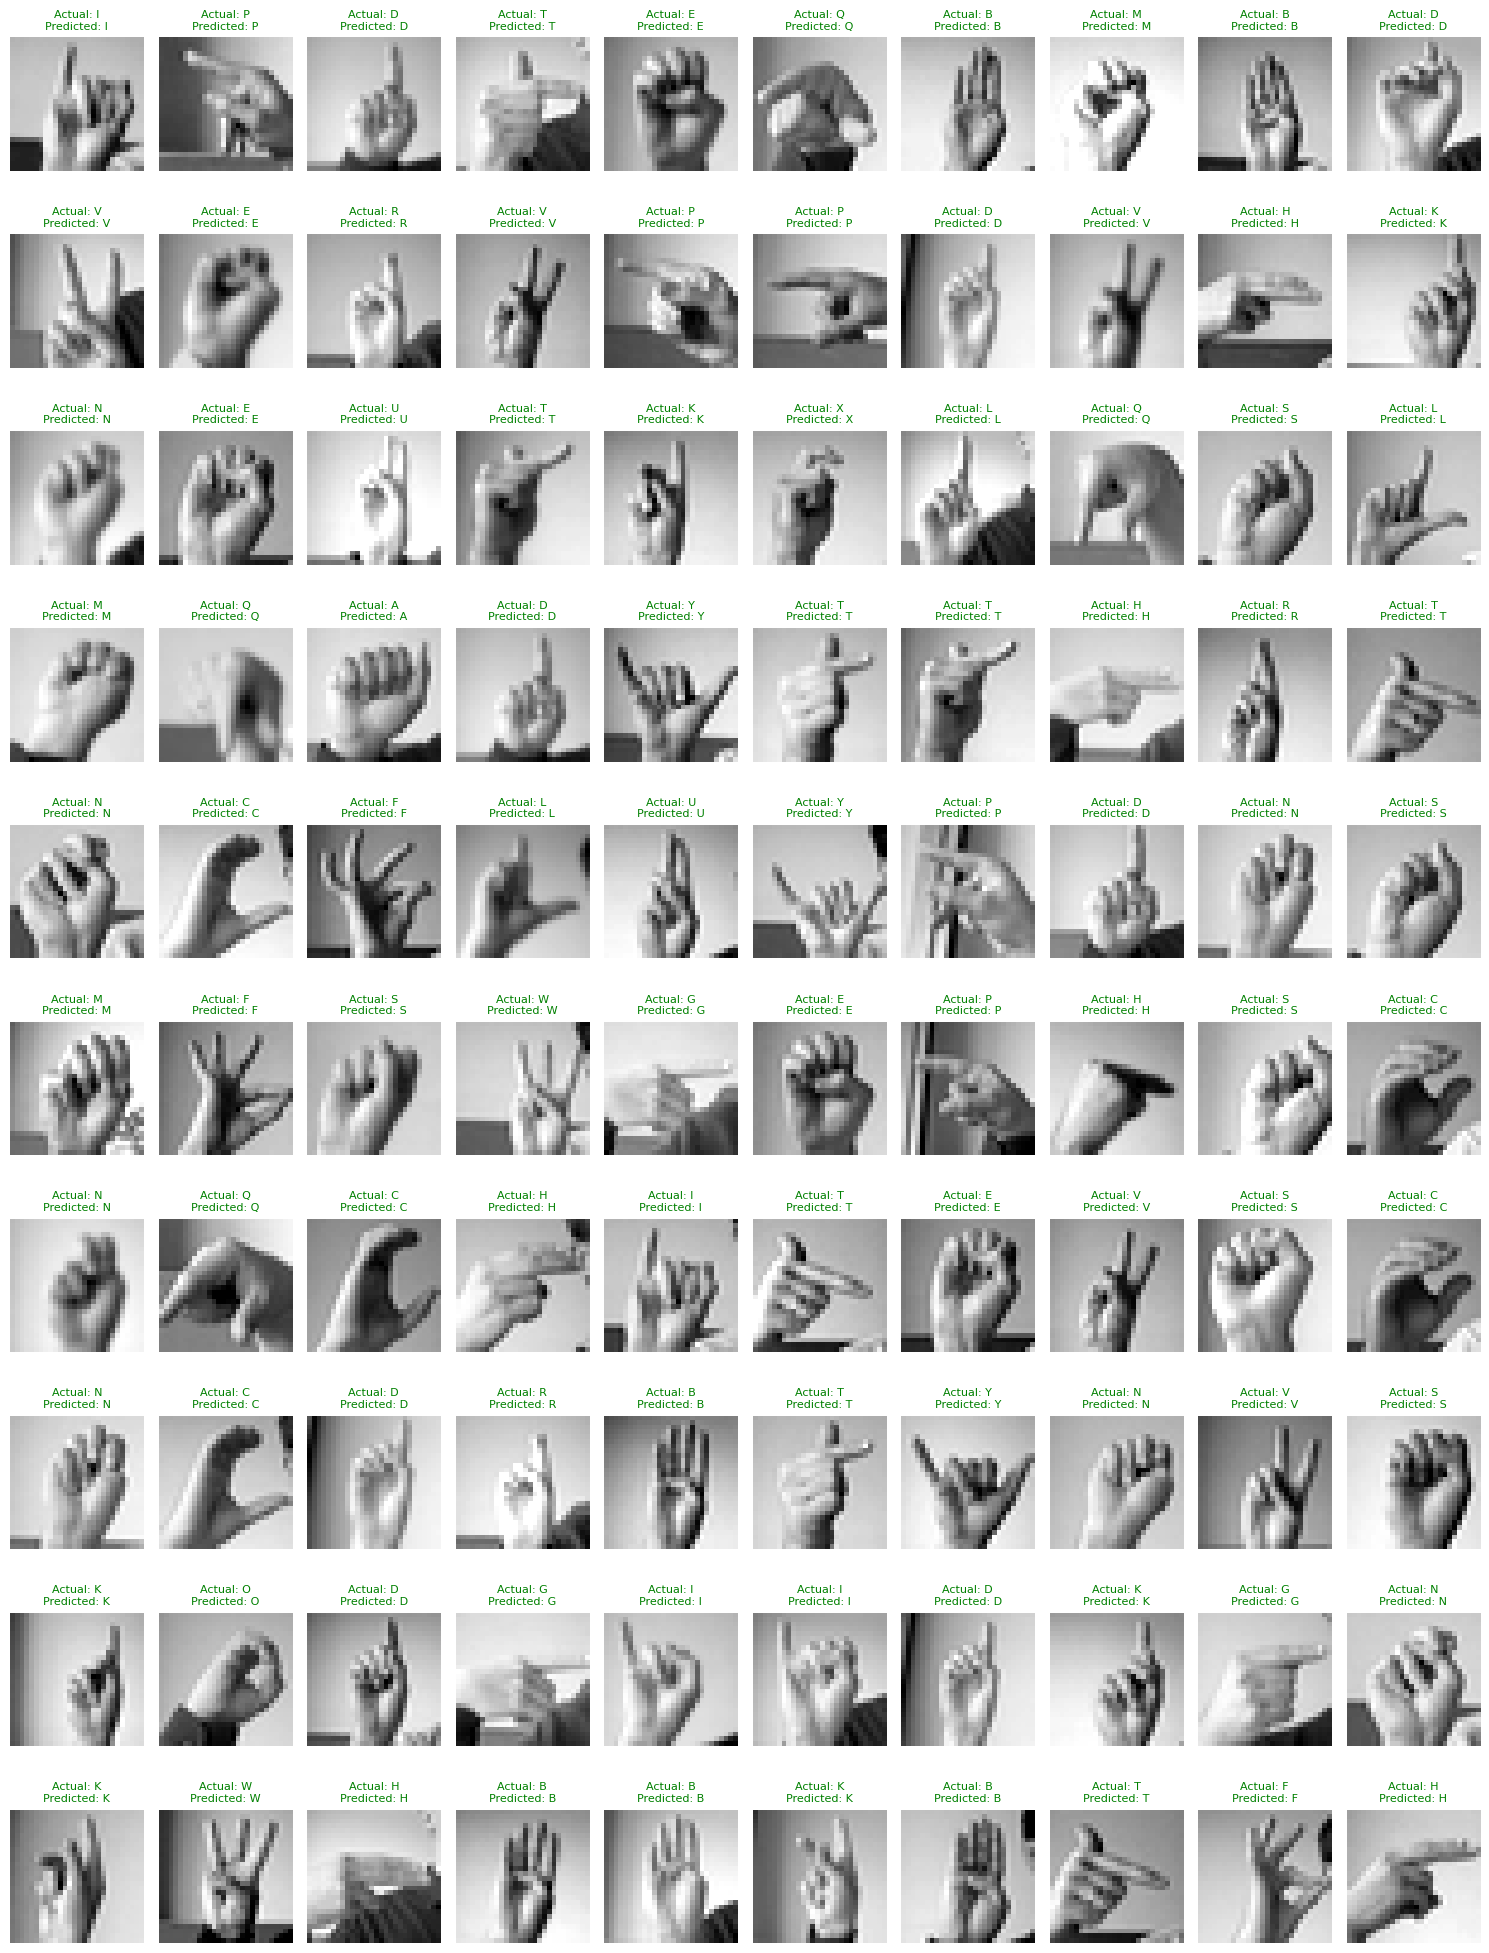

In [8]:
label_to_letter = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
    10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T',
    20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'
}

def preprocess_image(image):
    return PILImage.create(image)

def get_predictions(df, indices, learner):
    actual_labels = []
    predicted_labels = []
    images = []

    for idx in indices:
        sample_image = preprocess_image(df.iloc[idx]['image'])
        actual_label = df.iloc[idx]['label']
        
        pred_class, _, _ = learner.predict(sample_image)
        
        images.append(np.array(sample_image))
        actual_labels.append(actual_label)
        predicted_labels.append(pred_class)
    
    return images, actual_labels, predicted_labels

random_indices = random.sample(range(len(test_df)), 100)

images, actual_labels, predicted_labels = get_predictions(test_df, random_indices, learn)

num_images = len(images)
cols = 10
rows = num_images // cols + (num_images % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 2))

axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    border_color = 'green' if int(actual_labels[i]) == int(predicted_labels[i]) else 'red'

    actual_letter = label_to_letter.get(int(actual_labels[i]), 'Unknown')
    predicted_letter = label_to_letter.get(int(predicted_labels[i]), 'Unknown')

    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Actual: {actual_letter}\nPredicted: {predicted_letter}", fontsize=8, color=border_color)
    ax.axis('off')
    
    for spine in ax.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(2)

for j in range(num_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [9]:
learn.export('./models/sign_language_model_v2.pkl')

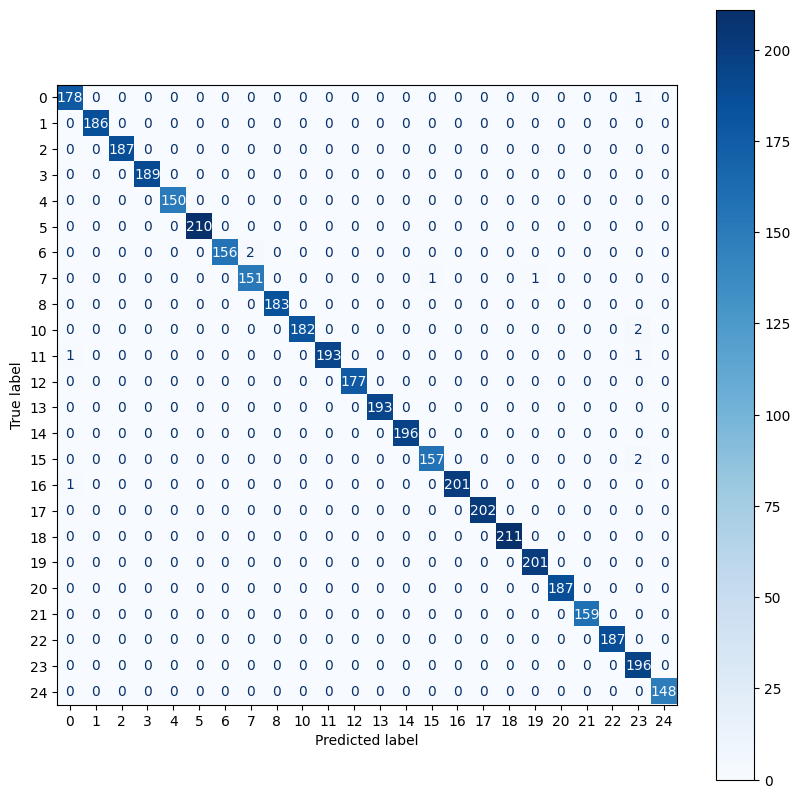

In [10]:
preds, targs = learn.get_preds()

cm = confusion_matrix(targs, preds.argmax(dim=1), labels=range(len(dls.vocab)))

plt.figure(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
disp.plot(cmap='Blues', ax=plt.gca())

# Show plot
plt.show()